---

# Apresentação

---

## Resumo
> Tendo em vista a importância do Ibovespa como indicador de desempenho do mercado de capitais brasileiro, neste trabalho, buscou-se aplicar algoritmos de aprendizado de máquina para prever o comportamento do índice, com o intuito de auxiliar possíveis investidores e entusiastas do mercado financeiro em sua tomada de decisão.

## Objetivo
> Aplicar algoritmos de Aprendizado de Máquina para, dado um dia, prever o valor de fechamento do Ibovespa, a partir da análise histórica até o dia anterior.

## Notas
> Este Código foi desenvolvido em Python no Google Colaboratory e seu funcionamento está a ele relacionado.

> **Para um melhor acompanhamento**, [visualize através do Colab](https://colab.research.google.com/drive/11Lxkfq3mz8-NwSdLngLeKLgC-4sOzrVR?usp=sharing) utilizando os índices.

---

# Bibliotecas, Funções e Constantes

---

In [1]:
# @title Instalando dependências externas

!pip install yfinance

In [2]:
# @title Importando as bibliotecas necessárias

# API
import yfinance as yf

# Ajuste dos dados
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Treinamento
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Algoritmos
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

# Métricas
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, r2_score

# Gráficos
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# Manipulação
import pandas as pd
import numpy as np

In [3]:
# @title Constantes

START_DATE = '2004-01-01'
END_DATE = '2024-01-01'

# Forma de ajuste dos dados
SCALER = StandardScaler()
# SCALER = MinMaxScaler()

# Modelo
# MODEL = DecisionTreeRegressor(random_state=1)
# MODEL = SVR()
MODEL = LinearRegression()

OCULTAR_IBOVESPA_NO_TREINO = False

In [4]:
# @title Funções

def enhance_dataset(**datasets: dict[str, pd.DataFrame]) -> pd.DataFrame:
    enhanced_dataframes = []

    ibovespa = datasets.pop('ibovespa')
    ibovespa.drop(['Adj Close', 'Volume'], axis=1, inplace=True)
    ibovespa = ibovespa.add_prefix('ibovespa_')

    for name, df in datasets.items():
        if 'Adj Close' in df.columns:
          df.drop(['Adj Close', 'Volume'], axis=1, inplace=True)
        df = df.add_prefix(f'{name}_')

        temp_df = df.copy()
        df = df.reindex(ibovespa.index)
        enhanced_dataframes.append(df)

    enhanced_dataframes.insert(0, ibovespa)
    enhanced_data = pd.concat(enhanced_dataframes, axis=1)

    return enhanced_data

def plot_null(data: pd.DataFrame) -> pd.DataFrame:
  null_counts = data.isnull().sum()
  na_counts = data.isna().sum()
  infinity_counts = np.isinf(data).sum()
  negative_infinity_counts = np.isneginf(data).sum()

  summary_df = pd.DataFrame({
      'null_counts': null_counts,
      'na_counts': na_counts,
      'infinity_counts': infinity_counts,
      'negative_infinity_counts': negative_infinity_counts
  })

  return summary_df.T

def to_binary(df: pd.DataFrame, field: str) -> pd.DataFrame:
  df_binary = df.copy()
  df_binary[field] = df_binary[field].pct_change() > 0
  return df_binary

def plot_confusion_matrix(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> None:
  y_true_binary = to_binary(y_true, "ibovespa_Close")
  y_pred_binary = to_binary(y_pred, "ibovespa_Close")

  conf_matrix = confusion_matrix(y_true_binary, y_pred_binary)
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Baixa", "Alta"])
  disp.plot(cmap='Blues')
  plt.xlabel('Predito')
  plt.ylabel('Real')
  plt.title(f'Matriz de confusão')

  TN, FP, FN, TP = conf_matrix.ravel()
  print(f"Verdadeiro Negativo: {TN}")
  print(f"Falso Positivo: {FP}")
  print(f"Falso Negativo: {FN}")
  print(f"Verdadeiro Positivo: {TP}")

  print(f"Recall: {TP / (TP + FN)}")
  print(f"Precisão: {TP / (TP + FP)}")

  plt.show()

def plot_predictions(y_test: pd.DataFrame, predictions: pd.DataFrame) -> None:
  print("Erro quadrático médio (MSE): %f" % mean_squared_error(y_test, predictions))
  print("Erro absoluto médio (MAE): %f" % mean_absolute_error(y_test, predictions))
  print("Coeficiente de determinação (R²): %f" % r2_score(y_test, predictions))
  print("Erro de raiz quadrática médio (RMSE): %f" % mean_squared_error(y_test, predictions, squared=False))

  plt.figure(figsize=(10, 6))
  plt.plot(y_test.index, y_test.values, label='Valores reais')
  plt.plot(predictions.index, predictions, label='Valores preditos', alpha=0.7)
  plt.title(f'Predito vs Real')
  plt.xlabel('Tempo')
  plt.ylabel('Valor')

  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=20))

  plt.xticks(rotation=45)
  plt.legend()
  plt.grid()
  plt.show()

---

# Pré-processamento

---

In [5]:
# @title Coleta de dados

ibovespa = yf.download('^BVSP', start=START_DATE, end=END_DATE, interval="1d") # R$
gold = yf.download('GC=F', start=START_DATE, end=END_DATE, interval="1d") # USD

crude_oil = yf.download('CL=F', start=START_DATE, end=END_DATE, interval="1d") # USD
heating_oil = yf.download('HO=F', start=START_DATE, end=END_DATE, interval="1d") # USD
natural_gas = yf.download('NG=F', start=START_DATE, end=END_DATE, interval="1d") # USD

eua_sp500 = yf.download('^GSPC', start=START_DATE, end=END_DATE, interval="1d")
china_sse = yf.download('000001.SS', start=START_DATE, end=END_DATE, interval="1d")

selic = pd.read_csv('./SELIC.csv', sep=";", index_col='Data')
selic.index.name = 'Date'
selic.index = pd.to_datetime(selic.index, format="%Y-%m-%d")

ipca = pd.read_csv('./IPCA.csv', sep=";", index_col='Data')
ipca.index.name = 'Date'
ipca.index = pd.to_datetime(ipca.index, format="%Y-%m-%d")

pib = pd.read_csv('./PIB.csv', sep=";", index_col='Data')
pib.index.name = 'Date'
pib.index = pd.to_datetime(pib.index, format="%Y-%m-%d")

dolar = pd.read_csv('./Dolar.csv', index_col='Data')
dolar.index = pd.to_datetime(dolar.index, format="%Y-%m-%d")
dolar.drop(['Var'], axis=1, inplace=True)
dolar = dolar.astype({'Close': 'float64', 'Open': 'float64', 'High': 'float64', 'Low': 'float64'})

temp_data = enhance_dataset(
    ibovespa=ibovespa,
    dolar=dolar,
    gold=gold,
    crude_oil=crude_oil,
    heating_oil=heating_oil,
    natural_gas=natural_gas,
    eua_sp500=eua_sp500,
    selic=selic,
    ipca=ipca,
    pib=pib,
    china_sse=china_sse
)

temp_data.index = temp_data.index.strftime('%Y-%m-%d')
data = temp_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
# @title Compreendendo o dataset

print(f'Quantidade de exemplos: {data.shape[0]}')
print(f'Quantidade de atributos: {data.shape[1]}')
plot_null(data)

Quantidade de exemplos: 4948
Quantidade de atributos: 35


,ibovespa_Open,ibovespa_High,ibovespa_Low,ibovespa_Close,dolar_Close,dolar_Open,dolar_High,dolar_Low,gold_Open,gold_High,...,eua_sp500_High,eua_sp500_Low,eua_sp500_Close,selic_Price,ipca_Price,pib_Price,china_sse_Open,china_sse_High,china_sse_Low,china_sse_Close
null_counts,0,0,0,0,0,0,0,0,133,133,...,125,125,125,0,0,0,319,319,319,319
na_counts,0,0,0,0,0,0,0,0,133,133,...,125,125,125,0,0,0,319,319,319,319
infinity_counts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative_infinity_counts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# @title Preenchendo valores inválidos

data = data.ffill().bfill()

In [8]:
plot_null(data)

,ibovespa_Open,ibovespa_High,ibovespa_Low,ibovespa_Close,dolar_Close,dolar_Open,dolar_High,dolar_Low,gold_Open,gold_High,...,eua_sp500_High,eua_sp500_Low,eua_sp500_Close,selic_Price,ipca_Price,pib_Price,china_sse_Open,china_sse_High,china_sse_Low,china_sse_Close
null_counts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
na_counts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
infinity_counts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative_infinity_counts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,ibovespa_Open,ibovespa_High,ibovespa_Low,ibovespa_Close,dolar_Close,dolar_Open,dolar_High,dolar_Low,gold_Open,gold_High,...,eua_sp500_High,eua_sp500_Low,eua_sp500_Close,selic_Price,ipca_Price,pib_Price,china_sse_Open,china_sse_High,china_sse_Low,china_sse_Close
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-02,22233.0,22450.0,22208.0,22445.0,2.8780,2.8980,2.898,2.8730,415.700012,422.500000,...,1118.849976,1105.079956,1108.479980,16.34,0.76,49797,1492.723999,1526.244019,1491.693970,1517.192993
2004-01-05,22445.0,23532.0,22445.0,23532.0,2.8470,2.8740,2.877,2.8450,415.700012,422.500000,...,1122.219971,1108.479980,1122.219971,16.34,0.76,49797,1516.796997,1568.814941,1516.697021,1568.353027
2004-01-06,23532.0,23976.0,23180.0,23576.0,2.8640,2.8470,2.870,2.8360,424.399994,424.299988,...,1124.459961,1118.439941,1123.670044,16.34,0.76,49797,1568.899048,1589.083008,1557.927002,1574.522949
2004-01-07,23576.0,23899.0,23320.0,23320.0,2.8595,2.8635,2.883,2.8485,423.000000,423.000000,...,1126.329956,1116.449951,1126.329956,16.33,0.76,49797,1574.102051,1594.996948,1565.087036,1587.203979
2004-01-08,23334.0,23718.0,23122.0,23717.0,2.8470,2.8550,2.872,2.8340,421.899994,422.000000,...,1131.920044,1124.910034,1131.920044,16.33,0.76,49797,1587.451050,1616.576050,1582.880005,1610.125977


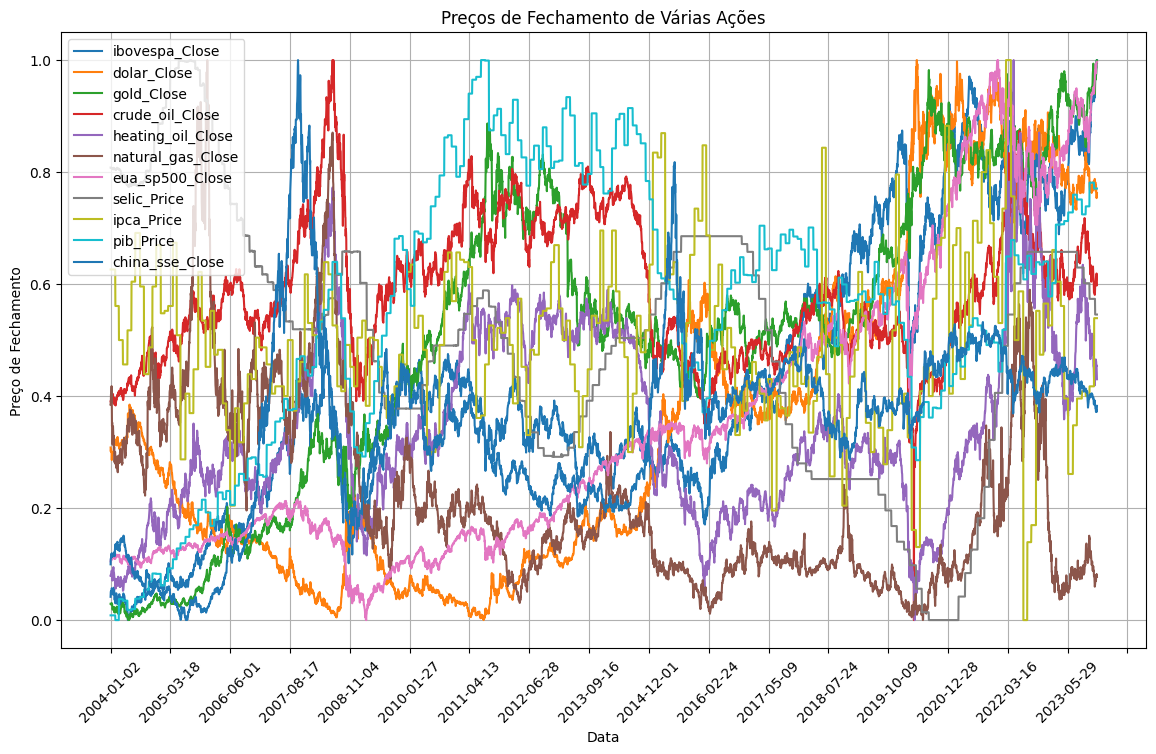

In [9]:
# @title Exibindo dataset

display(data.head())

# Normalizando dados para visualização
temp_data_normalized = pd.DataFrame(MinMaxScaler().fit_transform(data), columns=data.columns, index=data.index)

plt.figure(figsize=(14, 8))
for column in temp_data_normalized.columns:
    if 'Close' in column or 'Price' in column:
        plt.plot(temp_data_normalized['ibovespa_Close'].index, temp_data_normalized[column], label=column)

plt.title('Preços de Fechamento de Várias Ações')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=20))
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [10]:
# @title Ajuste dos dados

data_normalized = pd.DataFrame(SCALER.fit_transform(data), columns=data.columns, index=data.index)
data_normalized.head()

,ibovespa_Open,ibovespa_High,ibovespa_Low,ibovespa_Close,dolar_Close,dolar_Open,dolar_High,dolar_Low,gold_Open,gold_High,...,eua_sp500_High,eua_sp500_Low,eua_sp500_Close,selic_Price,ipca_Price,pib_Price,china_sse_Open,china_sse_High,china_sse_Low,china_sse_Close
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-02,-1.592614,-1.597647,-1.580567,-1.585297,-0.159559,-0.143319,-0.160897,-0.146757,-1.813584,-1.802725,...,-0.945942,-0.946004,-0.949602,1.339511,0.911709,-2.274849,-1.513146,-1.485692,-1.505268,-1.486549
2004-01-05,-1.585039,-1.559252,-1.572041,-1.546469,-0.184207,-0.162403,-0.177445,-0.169222,-1.813584,-1.802725,...,-0.942857,-0.942857,-0.936960,1.339511,0.911709,-2.274849,-1.484374,-1.435339,-1.474980,-1.425415
2004-01-06,-1.546199,-1.543497,-1.545599,-1.544897,-0.170690,-0.183872,-0.182961,-0.176443,-1.794420,-1.798781,...,-0.940806,-0.933638,-0.935626,1.339511,0.911709,-2.274849,-1.422101,-1.411365,-1.425036,-1.418042
2004-01-07,-1.544627,-1.546230,-1.540563,-1.554041,-0.174269,-0.170752,-0.172717,-0.166414,-1.797504,-1.801630,...,-0.939094,-0.935480,-0.933178,1.337068,0.911709,-2.274849,-1.415882,-1.404370,-1.416363,-1.402888
2004-01-08,-1.553274,-1.552652,-1.547686,-1.539860,-0.184207,-0.177510,-0.181385,-0.178047,-1.799927,-1.803821,...,-0.933977,-0.927650,-0.928035,1.337068,0.911709,-2.274849,-1.399927,-1.378846,-1.394809,-1.375497


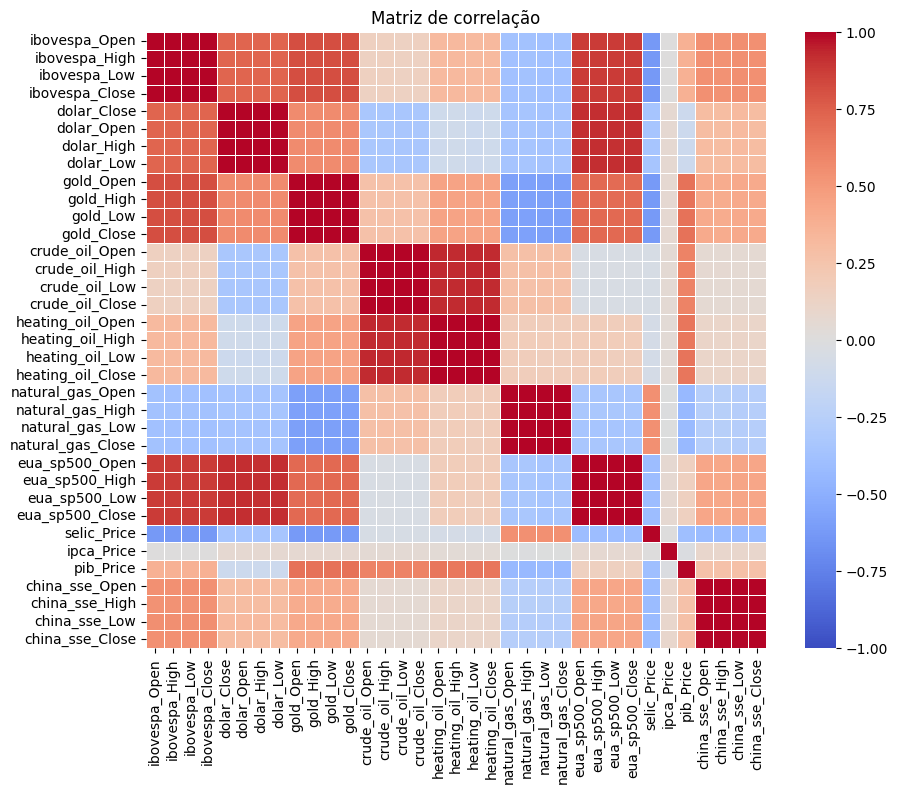

In [11]:
# @title Exibindo Matriz de correlação

plt.figure(figsize=(10, 8))
correlation_matrix = data_normalized.corr()
sns.heatmap(correlation_matrix, annot=False, center=0, vmin=-1, vmax=1,cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de correlação')
plt.show()

In [26]:
# @title Definindo conjunto de atributos e rótulo (X, y)

attributes_to_be_hidden = ['ibovespa_Close']

if OCULTAR_IBOVESPA_NO_TREINO:
 attributes_to_be_hidden += ['ibovespa_Open', 'ibovespa_High', 'ibovespa_Low']

X = data_normalized.drop(attributes_to_be_hidden, axis=1).shift(1).dropna()
y = data[['ibovespa_Close']].iloc[1:]

print(X.shape, y.shape)
display(X.head())
display(y.head())

(4947, 34) (4947, 1)


,ibovespa_Open,ibovespa_High,ibovespa_Low,dolar_Close,dolar_Open,dolar_High,dolar_Low,gold_Open,gold_High,gold_Low,...,eua_sp500_High,eua_sp500_Low,eua_sp500_Close,selic_Price,ipca_Price,pib_Price,china_sse_Open,china_sse_High,china_sse_Low,china_sse_Close
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-05,-1.592614,-1.597647,-1.580567,-0.159559,-0.143319,-0.160897,-0.146757,-1.813584,-1.802725,-1.794122,...,-0.945942,-0.946004,-0.949602,1.339511,0.911709,-2.274849,-1.513146,-1.485692,-1.505268,-1.486549
2004-01-06,-1.585039,-1.559252,-1.572041,-0.184207,-0.162403,-0.177445,-0.169222,-1.813584,-1.802725,-1.794122,...,-0.942857,-0.942857,-0.936960,1.339511,0.911709,-2.274849,-1.484374,-1.435339,-1.474980,-1.425415
2004-01-07,-1.546199,-1.543497,-1.545599,-0.170690,-0.183872,-0.182961,-0.176443,-1.794420,-1.798781,-1.790135,...,-0.940806,-0.933638,-0.935626,1.339511,0.911709,-2.274849,-1.422101,-1.411365,-1.425036,-1.418042
2004-01-08,-1.544627,-1.546230,-1.540563,-0.174269,-0.170752,-0.172717,-0.166414,-1.797504,-1.801630,-1.793015,...,-0.939094,-0.935480,-0.933178,1.337068,0.911709,-2.274849,-1.415882,-1.404370,-1.416363,-1.402888
2004-01-09,-1.553274,-1.552652,-1.547686,-0.184207,-0.177510,-0.181385,-0.178047,-1.799927,-1.803821,-1.795230,...,-0.933977,-0.927650,-0.928035,1.337068,0.911709,-2.274849,-1.399927,-1.378846,-1.394809,-1.375497


,ibovespa_Close
Date,
2004-01-05,23532.0
2004-01-06,23576.0
2004-01-07,23320.0
2004-01-08,23717.0
2004-01-09,23917.0


---

# Extração de padrões

---

---

## Métodos de validação

---

Erro quadrático médio (MSE): 3389792.756485
Erro absoluto médio (MAE): 1316.787330
Coeficiente de determinação (R²): 0.974402
Erro de raiz quadrática médio (RMSE): 1841.138983


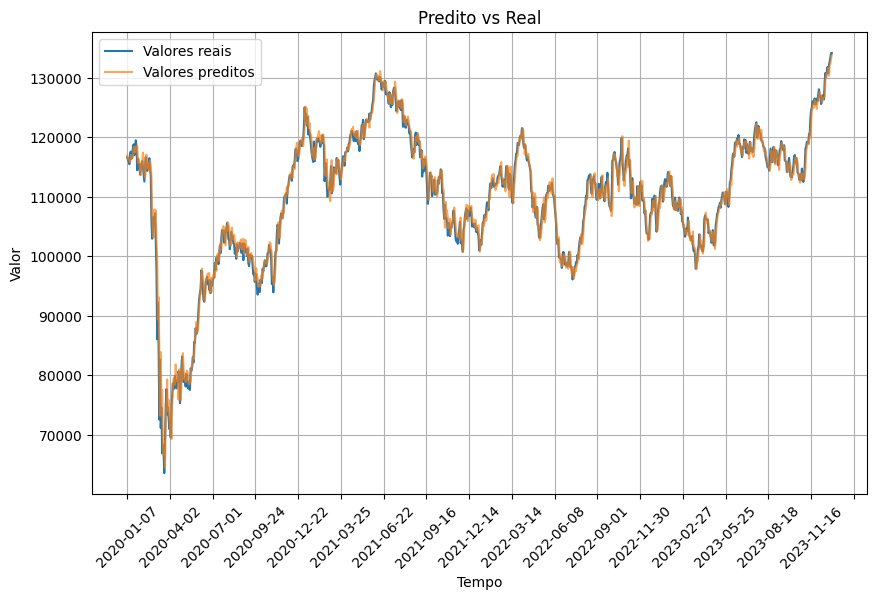

In [27]:
# @title Holdout (80/20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=False)

MODEL.fit(X_train, y_train)

predictions = MODEL.predict(X_test)
predictions_dataframe = pd.DataFrame(predictions, columns=y_test.columns, index=y_test.index)

plot_predictions(y_test.copy(), predictions_dataframe.copy())

Verdadeiro Negativo: 224
Falso Positivo: 257
Falso Negativo: 248
Verdadeiro Positivo: 261
Recall: 0.5127701375245579
Precisão: 0.5038610038610039


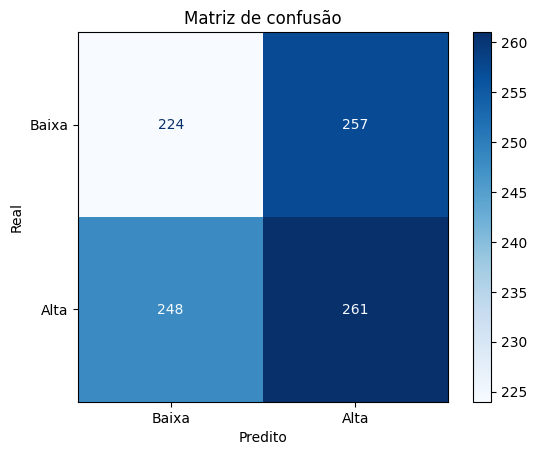

In [28]:
# @title Discretização de classe - Matriz de Confusão

plot_confusion_matrix(y_test.copy(), predictions_dataframe.copy())

Erro quadrático médio (MSE): 1752287.7297021553
Erro absoluto médio (MAE): 963.7670539917799
Coeficiente de determinação (R²): 0.965983877802655
Erro de raiz quadrática médio (RMSE): 1264.5355336272683


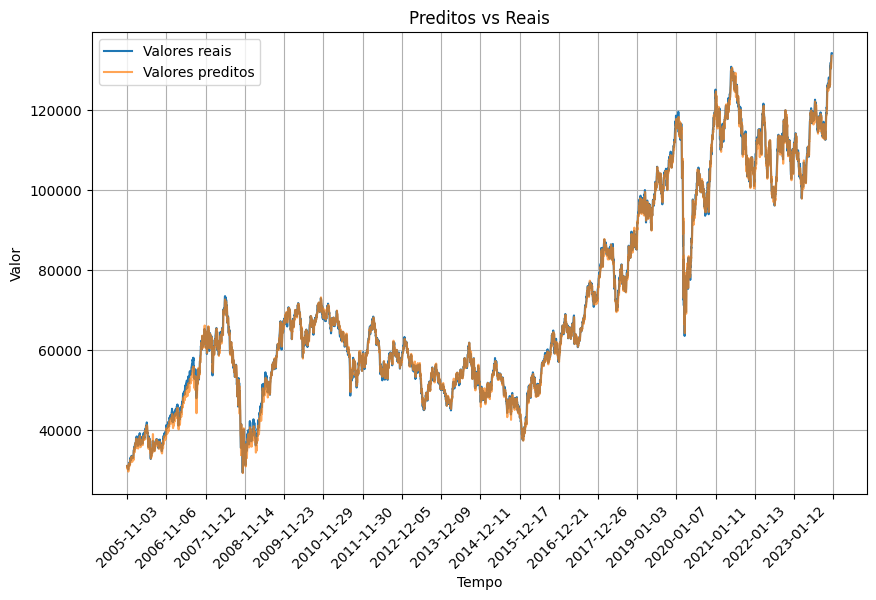

In [29]:
# @title K-fold (10 folds)

tscv = TimeSeriesSplit(n_splits=10)

r2_scores = []
mse_scores = []
mae_scores = []
rmse_scores = []

all_predictions = []
all_true_values = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    MODEL.fit(X_train, y_train)

    predictions = MODEL.predict(X_test)

    mse_scores.append(mean_squared_error(y_test, predictions))
    mae_scores.append(mean_absolute_error(y_test, predictions))
    r2_scores.append(r2_score(y_test, predictions))
    rmse_scores.append(mean_squared_error(y_test, predictions, squared=False))

    all_predictions.append(pd.DataFrame(predictions, index=y_test.index, columns=y_test.columns))
    all_true_values.append(pd.DataFrame(y_test, index=y_test.index))

all_predictions = pd.DataFrame(pd.concat(all_predictions))
all_true_values = pd.DataFrame(pd.concat(all_true_values))

print(f"Erro quadrático médio (MSE): {np.mean(mse_scores)}")
print(f"Erro absoluto médio (MAE): {np.mean(mae_scores)}")
print(f"Coeficiente de determinação (R²): {np.mean(r2_scores)}")
print(f"Erro de raiz quadrática médio (RMSE): {np.mean(rmse_scores)}")

plt.figure(figsize=(10, 6))
plt.plot(all_true_values.index, all_true_values.values, label='Valores reais')
plt.plot(all_predictions.index, all_predictions.values, label='Valores preditos', alpha=0.7)
plt.title('Preditos vs Reais')
plt.xlabel('Tempo')
plt.ylabel('Valor')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=20))
plt.xticks(rotation=45)

plt.legend()
plt.grid()
plt.show()


Verdadeiro Negativo: 1040
Falso Positivo: 1121
Falso Negativo: 1131
Verdadeiro Positivo: 1198
Recall: 0.5143838557320739
Precisão: 0.5166019836136265


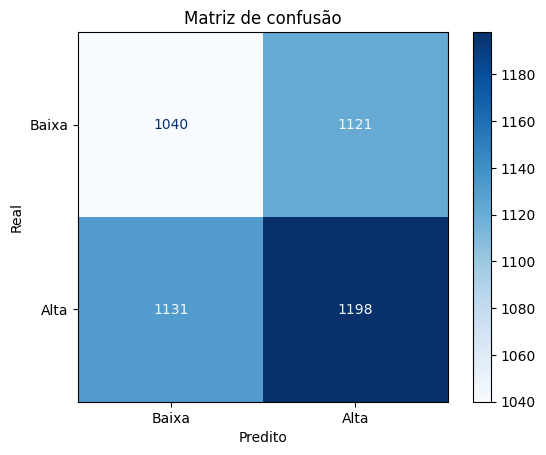

In [30]:
# @title Discretização de classe - Matriz de Confusão

plot_confusion_matrix(all_true_values.copy(), all_predictions.copy())